In [1]:
#Libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from scipy.stats import shapiro, normaltest, boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SequentialFeatureSelector

import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [335]:
data = pd.read_csv('interview_dataset.csv')

treatment company          object
azimuth                   float64
md (ft)                     int64
tvd (ft)                  float64
date on production         object
operator                   object
footage lateral length    float64
well spacing              float64
porpoise deviation        float64
porpoise count              int64
shale footage               int64
acoustic impedance        float64
log permeability          float64
porosity                  float64
poisson ratio             float64
water saturation          float64
toc                       float64
vcl                       float64
p-velocity                float64
s-velocity                float64
youngs modulus            float64
isip                      float64
breakdown pressure        float64
pump rate                   int64
total number of stages      int64
proppant volume           float64
proppant fluid ratio      float64
production                float64
dtype: object


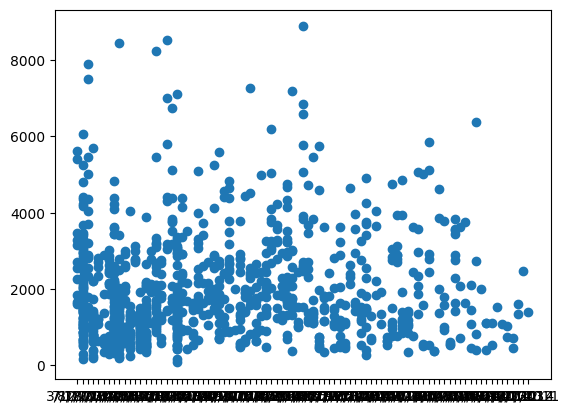

In [336]:
#Let's review that data types are correct
print(data.dtypes)
#data['date on production'] = pd.to_datetime(data['date on production'])
#Date on production has now a date time format

fig, ax = plt.subplots()
ax.scatter(x = data['date on production'], y = data['production'])
#Date on production is not relevant to our study
data.drop(['date on production'], axis=1,inplace=True)


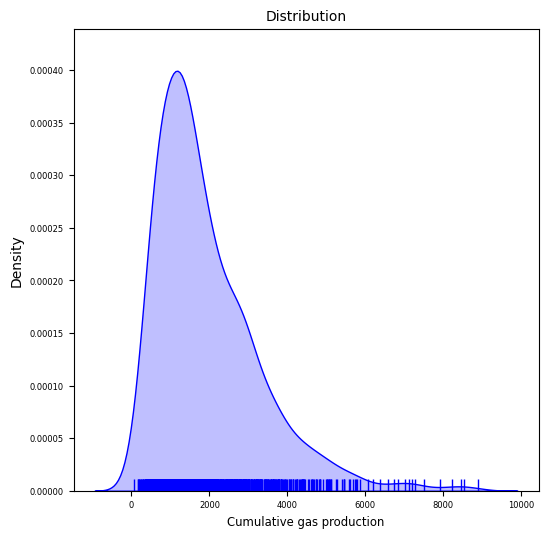

In [337]:
#The dependent variable has long tails, we must take this into account when we are creating the models
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.kdeplot(
    data['production'],
    fill    = True,
    color   = "blue",
    ax      = axes
)
sns.rugplot(
    data['production'],
    color   = "blue",
    ax      = axes
)
axes.set_title("Distribution", fontsize = 'medium')
axes.set_xlabel('Cumulative gas production', fontsize='small') 
axes.tick_params(labelsize = 6)

#

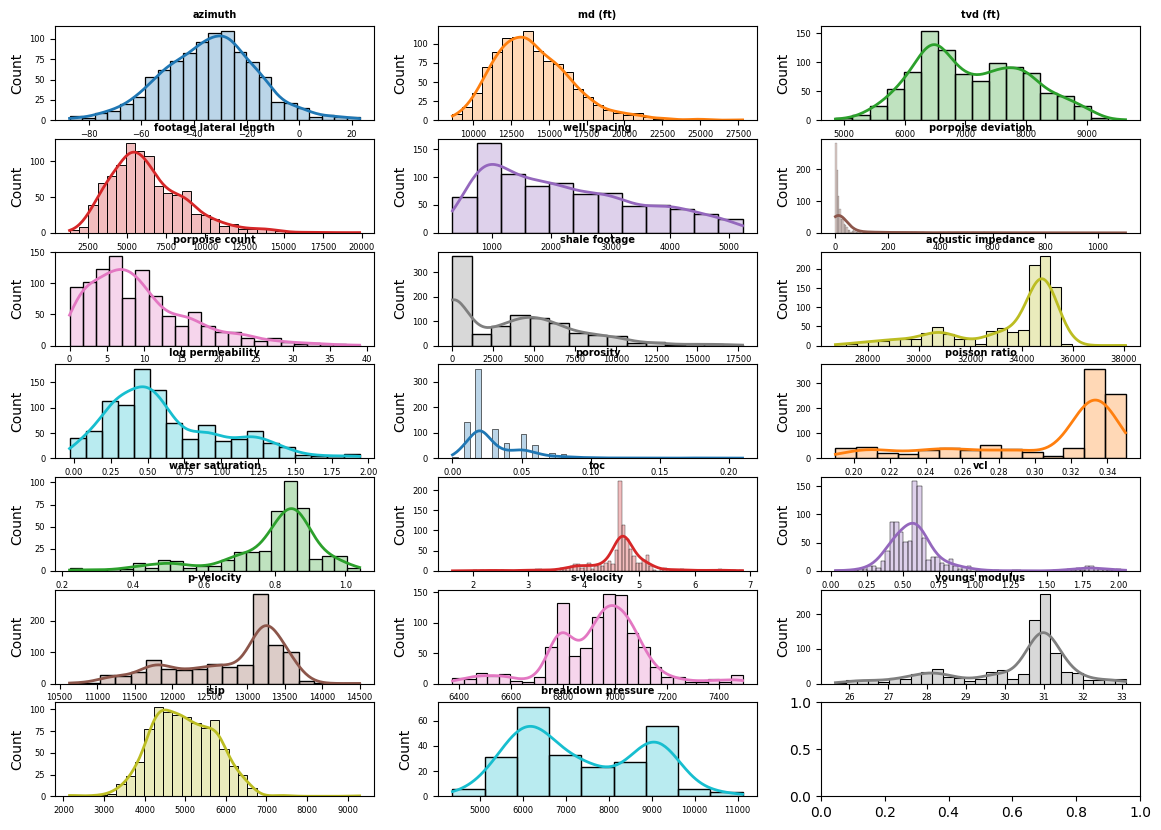

In [338]:
#There are many distributions among independent variables, and variables like md(ft), acoustic inpedance, toc, s-velocity, young modulus and pump rate, with long tails in their distribution
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(14, 10))
axes = axes.flat
num_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_columns = num_columns.drop('production')

try:
    for i, colum in enumerate(num_columns):
        sns.histplot(
            data     = data,
            x        = colum,
            stat     = "count",
            kde      = True,
            color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
            line_kws = {'linewidth': 2},
            alpha    = 0.3,
            ax       = axes[i]
        )
        axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
        axes[i].tick_params(labelsize = 6)
        axes[i].set_xlabel("")
        
        
    fig.tight_layout()
    plt.subplots_adjust(top = 0.9)
    fig.suptitle('Numerical variables distritubtion', fontsize = 10, fontweight = "bold");
except:
    pass

<Axes: title={'center': 'Production vs Operator'}, xlabel='operator', ylabel='production'>

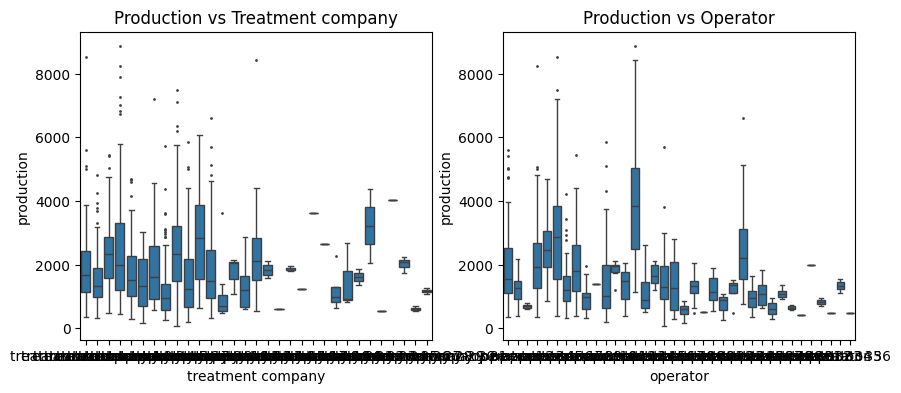

In [339]:
#There are two categorical variables, both correspond to companies chosen by the owner of the well to do the job. 
#There is a possibility that some companies have better performance than others, we should explore that possibility
#Let's plot the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title('Production vs Treatment company')
sns.boxplot(x="treatment company", y="production", data=data, ax=axs[0],fliersize=1)

axs[1].set_title('Production vs Operator')
sns.boxplot(x="operator", y="production", data=data, ax=axs[1],fliersize=1)

#We can perform an anova to test the differences in production average between companies, but plots give us enough information, clearly, there are differences.
#For now, these variables will remain in the model

                         azimuth   md (ft)  tvd (ft)  footage lateral length  \
azimuth                 1.000000  0.090436  0.082579                0.071710   
md (ft)                 0.090436  1.000000  0.237358                0.932205   
tvd (ft)                0.082579  0.237358  1.000000               -0.107306   
footage lateral length  0.071710  0.932205 -0.107306                1.000000   
well spacing            0.000537 -0.001224  0.003522               -0.006977   
porpoise deviation     -0.044368 -0.021909 -0.008944               -0.015157   
porpoise count          0.009206 -0.007777  0.001492               -0.011271   
shale footage          -0.027894 -0.020964  0.017676               -0.034346   
acoustic impedance     -0.069808 -0.024601  0.007656               -0.031960   
log permeability        0.168435  0.046531  0.133295                0.001960   
porosity                0.160878  0.024436  0.255719               -0.061093   
poisson ratio          -0.216835  0.1418

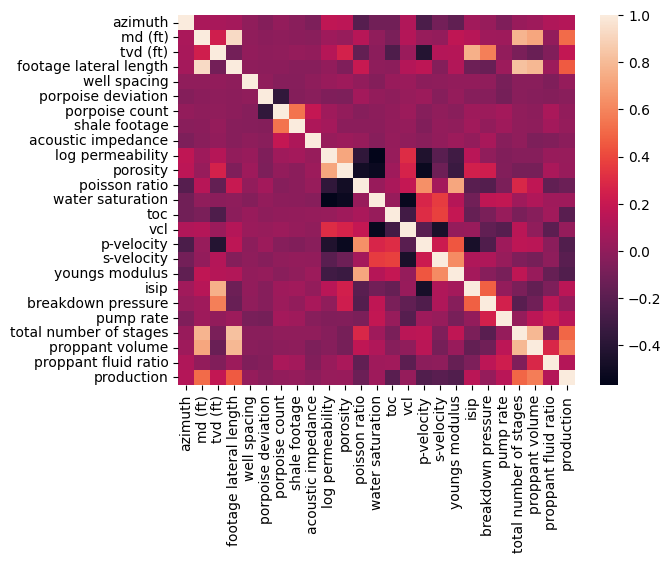

In [340]:
#¿What about correlation among variables? Note: Pandas is NaN friendly
print(data.corr(numeric_only=True))
sns.heatmap(data.corr(numeric_only=True))
#The linear relation between md and footage lateral length is too high, almost perfect according to the pearson correlation, we can keep footage lateral length as it contains the same information as md.
#Note: footage lateral length and md pearson coefficient against production are very similar (0.05 higher for md), but i decided keep footage lateral length because, in horizontal wells, the lateral part is the one in contact with the reservoir
data.drop(['md (ft)'], axis=1,inplace=True)
print(data.head())

treatment company           0
azimuth                    55
tvd (ft)                   20
operator                    0
footage lateral length      0
well spacing              156
porpoise deviation          0
porpoise count              0
shale footage               0
acoustic impedance          0
log permeability            0
porosity                  119
poisson ratio               0
water saturation          577
toc                        21
vcl                         0
p-velocity                  0
s-velocity                  0
youngs modulus             19
isip                       77
breakdown pressure        744
pump rate                   0
total number of stages      0
proppant volume           132
proppant fluid ratio        0
production                  0
dtype: int64


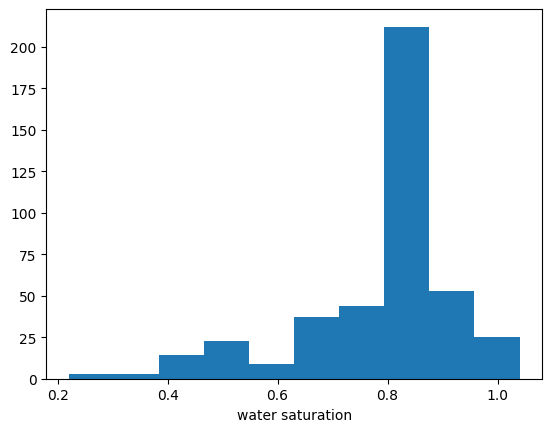

          azimuth     tvd (ft)  footage lateral length  well spacing  \
count  945.000000   980.000000             1000.000000    844.000000   
mean   -33.905735  7103.620408             6387.049510   2223.227174   
std     17.975658   896.947293             2520.330314   1255.063341   
min    -87.250000  4859.000000             1329.000000    335.458620   
25%    -46.220001  6407.000000             4668.000000   1084.525475   
50%    -32.990002  6977.000000             5927.000000   1999.295250   
75%    -22.580000  7820.000000             7744.000000   3090.201450   
max     22.940001  9639.000000            19849.000000   5225.089400   

       porpoise deviation  porpoise count  shale footage  acoustic impedance  \
count         1000.000000     1000.000000    1000.000000         1000.000000   
mean            50.457090        9.443000    3784.827000        33492.835400   
std            118.436695        6.882596    3703.775191         2074.387344   
min              0.030000      

In [341]:
#We have to review if there is missing data
print(data.isnull().sum())
#azimuth, TVD, well spacing, porosity, water saturation, TOC, young modulus, isip, breakdown pressure and proppant volume columns have missing data.
#We can try to impute breakdown pressure values, but it has more than 70% of its data missed. Drop this columns migh be a better option
data.drop(['breakdown pressure'], axis=1,inplace=True)

fig, ax = plt.subplots(1, 1)
plt.hist(data['water saturation'])
ax.set_xlabel('water saturation')
plt.show()
#In the case of water saturation, it has more than 50% of its data missed, and I know that, usually, this value is crucial in wells production, even though its pearson coefficient with production is low
#Therefore, I'm going to create a dataset without this variable,and keep it in the original, at least for now
data_wo_ws = data.drop(['water saturation'], axis=1)
#We will impute the rest of the variables later

print(data.describe())
#Apparently, there are no strange data, something like a negative lenght, spacing or pressure

In [342]:
#I'm going to create models for three cases, one omitting rows with null data, and the other two with different approached to the imputations

#Splitting data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop('production', axis = 'columns'), data['production'], train_size   = 0.8, random_state = 1234, shuffle = True)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_wo_ws.drop('production', axis = 'columns'), data_wo_ws['production'], train_size   = 0.8, random_state = 1234, shuffle = True)
X_train_2.reset_index(drop=True, inplace=True)
X_test_2.reset_index(drop=True, inplace=True)
y_train_2.reset_index(drop=True, inplace=True)
y_test_2.reset_index(drop=True, inplace=True)

#Start with the preprocessing 
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols_wo_ws = X_train_2.select_dtypes(include=['float64', 'int']).columns.to_list()

#Numerical data
numeric_transformer_1 = Pipeline(steps=[('imputer', IterativeImputer())])
numeric_transformer_2 = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10))])

#Categorical columns have too many categories, is better not to use OneHotEncoding, otherwise, we may have dimensionality problems
categorical_transformer = Pipeline(steps=[('encoding', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))] )
#categorical_transformer = Pipeline(steps=[('encoding', FeatureHasher(n_features=40, input_type='string'))] )

preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer_1, numeric_cols),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")
preprocessor_2 = ColumnTransformer(transformers=[('numeric', numeric_transformer_2, numeric_cols),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")
preprocessor_3 = ColumnTransformer(transformers=[('numeric', numeric_transformer_1, numeric_cols_wo_ws),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")
preprocessor_4 = ColumnTransformer(transformers=[('numeric', numeric_transformer_2, numeric_cols_wo_ws),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")

#Let's start with the simplest model
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)
X_train_prep = sm.add_constant(X_train_prep)
X_test_prep = sm.add_constant(X_test_prep)
model = sm.OLS(y_train, X_train_prep).fit()
print(model.summary())
y_pred_test = model.predict(X_test_prep)

X_train_prep_2 = preprocessor_2.fit_transform(X_train)
X_test_prep_2  = preprocessor_2.transform(X_test)
X_train_prep_2 = sm.add_constant(X_train_prep_2)
X_test_prep_2 = sm.add_constant(X_test_prep_2)
model_2 = sm.OLS(y_train, X_train_prep_2).fit()
print(model_2.summary())
y_pred_test_2 = model_2.predict(X_test_prep_2)

X_train_prep_3 = preprocessor_3.fit_transform(X_train_2)
X_test_prep_3  = preprocessor_3.transform(X_test_2)
X_train_prep_3 = sm.add_constant(X_train_prep_3)
X_test_prep_3 = sm.add_constant(X_test_prep_3)
model_3 = sm.OLS(y_train_2, X_train_prep_3).fit()
print(model_3.summary())
y_pred_test_3 = model_3.predict(X_test_prep_3)

X_train_prep_4 = preprocessor_4.fit_transform(X_train_2)
X_test_prep_4 = preprocessor_4.transform(X_test_2)
X_train_prep_4 = sm.add_constant(X_train_prep_4)
X_test_prep_4 = sm.add_constant(X_test_prep_4)
model_4 = sm.OLS(y_train_2, X_train_prep_4).fit()
print(model_4.summary())
y_pred_test_4 = model_4.predict(X_test_prep_4)

#We have a regression problem, then, RMSE is a good metric to measure and compare among models
print('RMSE Iterative imputer',mean_squared_error(y_test, y_pred_test, squared = False))
print('RMSE KNN imputer',mean_squared_error(y_test, y_pred_test_2, squared = False))
print('RMSE Without WS Iterative imputer',mean_squared_error(y_test_2, y_pred_test_3, squared = False))
print('RMSE Without WS KNN imputer',mean_squared_error(y_test_2, y_pred_test_4, squared = False))

#The difference between models with and without water saturation is tiny, and models without it have lower RMSE, then we can drop it
#Iterative imputer and KNN imputer has a similar RMSE in both cases, but, KNN imputer increases RMSE in both cases too, let's compare if they affects multicollinearity using variance inflation factor
vif = pd.DataFrame()
vif['Vars'] = X_train_prep_4.columns
vif['VIF Iterative imputer'] = [variance_inflation_factor(X_train_prep_3.values, i) for i in range(X_train_prep_3.shape[1])]
vif['VIF KNN imputer'] = [variance_inflation_factor(X_train_prep_4.values, i) for i in range(X_train_prep_4.shape[1])]
vif['Diff'] = vif['VIF Iterative imputer']-vif['VIF KNN imputer']
print(vif)
#In most cases of imputed variables, iterative imputer increase VIF, but, this is not a big change.
#Young modulus has a high vif, but continues below allowed threshold (vif<10). We can drop it and see if RMSE changes
y_train_5, y_test_5 =  y_train_2, y_test_2
X_train_prep_5 = X_train_prep_3.drop(['youngs modulus'], axis=1)
X_test_prep_5 =  X_test_prep_3.drop(['youngs modulus'], axis=1)
model_5 = sm.OLS(y_train_2, X_train_prep_5).fit()
y_pred_test_5 = model_5.predict(X_test_prep_5)
print('RMSE With out Young modulus',mean_squared_error(y_test_5, y_pred_test_5, squared = False))
#From 1093 to 1120, it's better to keep Young modulus

#Let's start saving models to compare each other at the end of this exercise
model_solution = {}

#Create our custom transformer to use just the columns the model needs
class ColumnExtractor(object):
    def __init__(self, cols):
        self.cols = cols
        
    def transform(self, X, y=None):
        cols = X.loc[ : , self.cols] # column 3 and 4 are "extracted"
        return cols

    def fit(self, X, y=None):
        return self

X_reg= X_train_prep_3.columns.drop('const')  

pipe = Pipeline([
                ('preprocessing', preprocessor_3),                 
                 ('ColumnExtractor',ColumnExtractor(X_reg)),                 
                 ('model', LinearRegression())
                 ])
pipe.fit(X_train_prep_3,y_train_2)
#y_pred= pipe.predict(X_test_2)

RMSE_test = mean_squared_error(y_test_2, y_pred_test_3, squared = False)
model_solution['Linear_model'] = {'RMSE_test':RMSE_test,'model':pipe,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':'Linear_Regression'}

                            OLS Regression Results                            
Dep. Variable:             production   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     40.20
Date:                Sat, 03 Feb 2024   Prob (F-statistic):          1.13e-118
Time:                        20:12:25   Log-Likelihood:                -6563.3
No. Observations:                 800   AIC:                         1.318e+04
Df Residuals:                     775   BIC:                         1.329e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   6725

Shapiro wilk  ShapiroResult(statistic=0.9413500428199768, pvalue=3.1124841069235005e-17)
D’Agostino’s  NormaltestResult(statistic=174.19871140011395, pvalue=1.490151561209288e-38)
Ljung-Box        lb_stat  lb_pvalue
12  10.302751   0.589419
P-value Pos box-cox 0.0006075616111047566
P-value after outlier detection 0.19252099096775055
RMSE 2542.428175350718


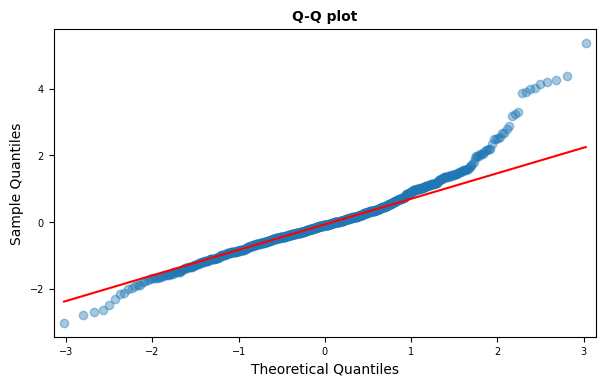

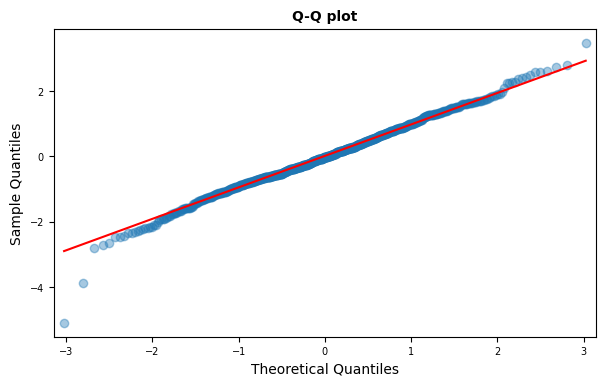

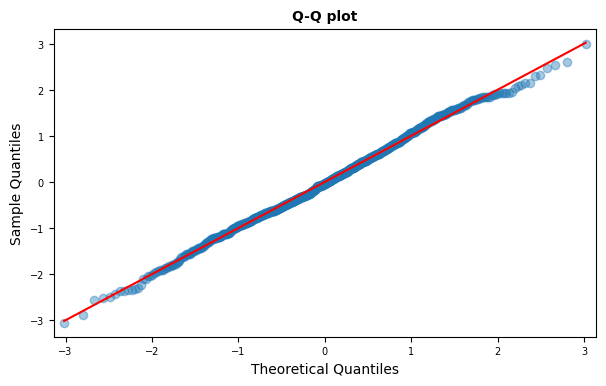

In [343]:
#Now we need to see if the model meets linear model assumptions using some hypothesis testing. In all cases, a p-value less than 0.5 (Reject null hypothesis) means that we don't meet the assumption
print('Shapiro wilk ',shapiro(model_3.resid))
print('D’Agostino’s ',normaltest(model_3.resid))
#p-value<0.05 Doesn't meet Normality assumption
sm.stats.diagnostic.het_goldfeldquandt(y_train_2, X_train_prep_3, drop=0.2)
#p-value<0.05 Doesn't meet Homoscedasticity assumption
lags = 12
print('Ljung-Box ',acorr_ljungbox(model_3.resid, lags=[lags], return_df=True))
#p-value>0.05 Meets Autocorrelation assumption

#To solve the normality problem, we'll do a box-cox transformation. Q-Q plot could give us some idea of the problem

#QQ-Plot before box-cox
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(model_3.resid,fit= True,line  = 'q',alpha = 0.4, lw = 2, ax=ax)
ax.set_title('Q-Q plot', fontsize = 10, fontweight = "bold")
ax.tick_params(labelsize = 7)


yt, lam= boxcox(y_train_2) #returns data,lambda
y_train_3 = pd.Series(yt)
model_999 = sm.OLS(y_train_3, X_train_prep_3).fit()
print('P-value Pos box-cox',shapiro(model_999.resid)[1])
y_pred_train = model_999.predict(X_train_prep_3)

#QQ-Plot after box-cox
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(model_999.resid,fit= True,line  = 'q',alpha = 0.4, lw = 2, ax=ax)
ax.set_title('Q-Q plot', fontsize = 10, fontweight = "bold")
ax.tick_params(labelsize = 7)

#There are some points away from qq-plot line, that's why we don't meet normality yet
influence = model_999.get_influence()

#I created this function to detect outliers/influential points using different methods. My thumb rule is: If one point is considered a outlier/influential point by more than 3 methods, I'll delete it
def OutliersDetection(influence, VarCount, ObsCount):
    #This function use five differents ways to detect outliers/influential points
    #This dictionary will store store the position of the outliers, with the key being the method
    Outliers = {}
    OutliersSummary = influence.summary_frame()
    p = VarCount
    n = ObsCount
    
    #abs(Standarized residuals)>3
    CutOffSR = 3
    Outliers['StandResid']=OutliersSummary.index[abs(OutliersSummary['standard_resid'])>CutOffSR].tolist()
    
    #Cooks distance >=1
    CutOffCD = 1
    Outliers['CooksDist'] = OutliersSummary.index[OutliersSummary['cooks_d']>=CutOffCD].tolist()
       
    #abs(DfFits) >= 2*(p/n)^(1/2) p->parameters number  n->Observations number
    CutOffDfF = 2*pow(p/n,1/2)
    Outliers['DfFits'] = OutliersSummary.index[abs(OutliersSummary['dffits'])>=CutOffDfF].tolist()
       
    #abs(CovRatio-1) >= 3*(p/n) p->parameters number  n->Observations number
    CutOffCR = 3*p/n
    Outliers['CovRatio'] = []
    cov_ratio = influence.cov_ratio
    for n,cov_ratio in enumerate(cov_ratio):
        if abs(cov_ratio-1) >= CutOffCR:
            Outliers['CovRatio'].append(n)
    
    #abs(DfBetas) >= 2/(n^(1/2)) n->Observations number
    CutOffDfB = 2/(pow(n,1/2))
    Outliers['DfBetas'] = []
    dfbetas = influence.dfbetas  
    for n,dfbetas in enumerate(dfbetas):
        if abs(max(dfbetas)) >= CutOffDfB:
            Outliers['DfBetas'].append(n)
    
    OutliersFreq = {}
    #Here we create a list with all the outliers
    OutliersCum = []
    for Method,OutliersMethod in Outliers.items():
        for Outlier in OutliersMethod:
            OutliersCum.append(Outlier)
    OutliersFreq = [OutliersCum.count(o) for o in OutliersCum]
    #This dictionary will storage the position of the outlier (key) and their frequency (value)
    OutliersCount = dict(list(zip(OutliersCum, OutliersFreq)))
    
    return Outliers, OutliersCount

X_train_prep_6 = X_train_prep_3.copy()
X_test_prep_6 = X_test_prep_3.copy()
X_train_prep_6.reset_index(drop=True, inplace=True)
VarCount = X_train_prep_6.shape[1]
ObsCount = X_train_prep_6.shape[0]

Outliers,OutliersCount = OutliersDetection(influence, VarCount, ObsCount)
OutliersRemove = []
#We will remove observations with residuals considered outliers
for Outlier,Count in OutliersCount.items():
    #We will list observations that are considered outliers by at least two methods
    if Count>=3:
        OutliersRemove.append(Outlier)
#If we had outliers that met the previous requeriments, we will remove them
if bool(OutliersRemove):                            
    X_train_prep_6.drop(OutliersRemove, axis=0, inplace=True)
    X_train_prep_6.reset_index(drop=True, inplace=True)

    IndicesList = sorted(OutliersRemove, reverse=True)
    # Traversing in the indices list
    for Index in IndicesList:
        # checking whether the corresponding iterator index is less than the list length
        if Index < len(y_train_3):
            # removing element by index using pop() function
            y_train_3.pop(Index)
            y_train_3.reset_index(drop=True, inplace=True)


model_6 = sm.OLS(y_train_3, X_train_prep_6).fit()
y_pred_train = model_6.predict(X_train_prep_6)
y_pred_test_6 = model_6.predict(X_test_prep_6)
#QQ-Plot after outlier detection
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(model_6.resid,fit= True,line  = 'q',alpha = 0.4, lw = 2, ax=ax)
ax.set_title('Q-Q plot', fontsize = 10, fontweight = "bold")
ax.tick_params(labelsize = 7)
print('P-value after outlier detection',shapiro(model_6.resid)[1])
sm.stats.diagnostic.het_goldfeldquandt(y_train_3, X_train_prep_6, drop=0.2)
#Now we meet normality assumption, but homocedasticity is still a problem, but we can continue with that

#save lambda to future regressions
lambd=lam
def target_transform(target):
    target_ = target.copy()
    if lambd is None:
        pass
    elif lambd == 0:
        target_ = np.log(target_)
    elif lambd != 0:
        target_ = ((target_**lambd)-1)/(lambd)
    return target_

def inverse_target_transform(target):
    target_ = target.copy()
    if lambd is None:
        pass
    elif lambd == 0:
        target_ = np.exp(target_)
    elif lambd != 0:
        target_ = (target_*lambd+1)**(lambd)
    return target_

X_train_prep_6.drop('const', axis='columns',inplace=True)

pipe = Pipeline([
                ('preprocessing', preprocessor_3),
                ('ColumnExtractor',ColumnExtractor(X_train_prep_6.columns)),                 
                ('model', LinearRegression())])
model = TransformedTargetRegressor(regressor = pipe, func = target_transform, inverse_func = inverse_target_transform)
model.fit(X_train_prep_6,y_train_3)
y_pred= model.predict(X_test_2)

RMSE_test = mean_squared_error(y_test_2, y_pred, squared = False)

print('RMSE',RMSE_test)
model_solution['Linear_model_norm'] = {'RMSE_test':RMSE_test,'model':model,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':'Linear_Regression'}
#Now the RMSE is even worst, but as we don't need some assumptions for the goal of this exercise, is not ma serious problem
#https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd
                

In [344]:
#Some variables could be interfering in the regression due to multicollinearity or other problems. Let's use stepwise regresion to select features
lr = LinearRegression()

X_train_prep_7 = X_train_prep_3.drop('const', axis='columns')  
X_test_prep_7 = X_test_prep_3.drop('const', axis='columns') 

sfs = SequentialFeatureSelector(lr, direction='forward', cv=5)
sfs.fit(X_train_prep_7, y_train_2)
feature_idx = sfs.get_support(indices=True)

X_train_sfs = X_train_prep_7.iloc[:, feature_idx]
X_test_sfs = X_test_prep_7.iloc[:, feature_idx]
X_reg= X_train_sfs.columns 

numeric_cols_sfs = X_train_sfs.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols_sfs = X_train_sfs.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor_5 = ColumnTransformer(transformers=[('numeric', numeric_transformer_1, numeric_cols_sfs),('cat', categorical_transformer, cat_cols_sfs)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")

pipe = Pipeline([
                ('preprocessing', preprocessor_5),                 
                 ('ColumnExtractor',ColumnExtractor(X_reg)),                 
                 ('model', LinearRegression())
                 ])
model = pipe.fit(X_train_sfs, y_train_2)

y_pred = model.predict(X_test_sfs)
RMSE_test = mean_squared_error(y_test_2, y_pred, squared = False)
print('RMSE after stepwise regression',RMSE_test)

model_solution['Linear_model_step_wise'] = {'RMSE_test':RMSE_test,'model':model,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':'Linear_Regression'}

#The RMSE reduction is not impressive, but now we have a less complex model.

RMSE after stepwise regression 1089.9707474102843


In [345]:
#Let's try more radical methods to address this problem

#It's important scale the data for most of the folowing ML models (If not, we can't loss accuracy, have slower convergence, etc...), then I'll add this step to the transformer
# With Standard scaler we can deal better with outliers 
numeric_cols = X_train_2.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train_2.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_transformer = Pipeline( steps=[('imputer', IterativeImputer()),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoding', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")

#Create validation data for neural networks
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_2, y_train_2, train_size = 0.8, random_state = 1234, shuffle = True)
#X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_prep_3, y_train_2, train_size = 0.8, random_state = 1234, shuffle = True)
X_train_NN.drop(['treatment company','operator'], axis=1,inplace=True)
X_val_NN.drop(['treatment company','operator'], axis=1,inplace=True)
         
preprocessor_NN = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols)],
                    remainder='passthrough',verbose_feature_names_out = False) #.set_output(transform="pandas")

#Let's put all together
Reg_models = ['Ridge','Lasso','Huber_Regressor','PCR','XGBoost','Neural_Network'] #
for Reg_model in Reg_models:
    if Reg_model == 'Ridge':
        pipe = Pipeline([('preprocessing', preprocessor),
                 ('ColumnExtractor',ColumnExtractor(X_train_2.columns)),
                 ('model', Ridge())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Lasso':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_2.columns)),
                 ('model', Lasso())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Huber_Regressor':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_2.columns)),
                 ('model', HuberRegressor())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10), 'model__epsilon': np.logspace(0, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True
        #print(model.outliers_) This Attribute belongs to HuberRegressor

    elif Reg_model == 'PCR':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_2.columns)),
                          ('reduce_dim', PCA()), ('regressor', LinearRegression())])
        param_grid = {'reduce_dim__n_components':  np.arange(1, X_train_2.shape[1] + 1)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'XGBoost':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_2.columns)),
                 ('model', XGBRegressor())])
        param_grid = {'model__nthread':[4], #when use hyperthread, xgboost may become slower
              'model__objective':['reg:linear'],'model__learning_rate': [0.01,0.03,0.05,0.07], 'model__max_depth': [5, 6, 7],'model__min_child_weight': [4],'model__silent': [1],'model__subsample': [0.7],
              'model__colsample_bytree': [0.7],'model__n_estimators': [500,1000]}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'Neural_Network':
        
        #How manyy layers, neurons, epochs and batch size?, which is the best activation function to this case?, 
        #should we use dropout?, which optimizer and loss function should we use?, early stopping?
        neural_network = Sequential()
        neural_network.add(Dense(160, input_shape=(X_train_NN.shape[1],), activation='relu')) # (features,)
        #¿neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(480, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(256, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(1, activation='linear')) # output node
        neural_network.summary() # see what your model looks like
        neural_network.compile(optimizer='Adam', loss='mse', metrics=['mse']) # compile the model
        es = EarlyStopping(monitor='val_loss',mode='min',patience=50, restore_best_weights = True) # early stopping callback 
        #scaler = StandardScaler()
        model = Pipeline([('ColumnExtractor',ColumnExtractor(X_train_NN.columns)),
                ('preprocessing', preprocessor_NN),
                ('model', neural_network)])
                
    #Fit model with regularization
    if Reg_model in ['Neural_Network']:
        model.fit(X_train_NN, y_train_NN, model__validation_data = (X_val_NN,y_val_NN), model__callbacks=[es], model__epochs=10, model__batch_size=5,model__verbose=1)     
    else:
        model.fit(X = X_train_2, y = y_train_2)

    X_reg= X_train_2.columns 
    y_pred = model.predict(X_test_2)
    RMSE_test = mean_squared_error(y_test_2, y_pred, squared = False)
    print('RMSE',Reg_model,RMSE_test,sep=' ')
    model_solution[Reg_model] = {'RMSE_test':RMSE_test,'model':model,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':Reg_model}

RMSE Ridge 1094.2456421522868
RMSE Lasso 1099.2766781869868
RMSE Huber_Regressor 1092.9345399723147
RMSE PCR 1092.8347135106444
RMSE XGBoost 844.3506030623928
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 160)               3520      
                                                                 
 dense_190 (Dense)           (None, 480)               77280     
                                                                 
 dense_191 (Dense)           (None, 256)               123136    
                                                                 
 dense_192 (Dense)           (None, 1)                 257       
                                                                 
Total params: 204193 (797.63 KB)
Trainable params: 204193 (797.63 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________________________________

In [346]:
#Now with most important features

X_train_sfs = X_train_prep_2.iloc[:, feature_idx]
X_test_sfs = X_test_prep_2.iloc[:, feature_idx]
X_reg= X_train_sfs.columns 

numeric_cols = X_train_sfs.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train_sfs.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_transformer = Pipeline( steps=[('imputer', IterativeImputer()),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoding', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")

#Create validation data for neural networks
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_sfs, y_train_2, train_size = 0.8, random_state = 1234, shuffle = True)
         
preprocessor_NN = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols)],
                    remainder='passthrough',verbose_feature_names_out = False) #.set_output(transform="pandas")

#Let's put all together
Reg_models = ['Ridge','Lasso','Huber_Regressor','PCR','XGBoost','Neural_Network'] #
for Reg_model in Reg_models:
    if Reg_model == 'Ridge':
        pipe = Pipeline([('preprocessing', preprocessor),
                 ('ColumnExtractor',ColumnExtractor(X_train_sfs.columns)),
                 ('model', Ridge())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Lasso':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_sfs.columns)),
                 ('model', Lasso())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Huber_Regressor':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_sfs.columns)),
                 ('model', HuberRegressor())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10), 'model__epsilon': np.logspace(0, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True
        #print(model.outliers_) This Attribute belongs to HuberRegressor

    elif Reg_model == 'PCR':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_sfs.columns)),
                          ('reduce_dim', PCA()), ('regressor', LinearRegression())])
        param_grid = {'reduce_dim__n_components':  np.arange(1, X_train_sfs.shape[1] + 1)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'XGBoost':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_sfs.columns)),
                 ('model', XGBRegressor())])
        param_grid = {'model__nthread':[4], #when use hyperthread, xgboost may become slower
              'model__objective':['reg:linear'],'model__learning_rate': [0.01,0.03,0.05,0.07], 'model__max_depth': [5, 6, 7],'model__min_child_weight': [4],'model__silent': [1],'model__subsample': [0.7],
              'model__colsample_bytree': [0.7],'model__n_estimators': [500,1000]}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'Neural_Network':
        
        #How manyy layers, neurons, epochs and batch size?, which is the best activation function to this case?, 
        #should we use dropout?, which optimizer and loss function should we use?, early stopping?
        neural_network = Sequential()
        neural_network.add(Dense(160, input_shape=(X_train_NN.shape[1],), activation='relu')) # (features,)
        #¿neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(480, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(256, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(1, activation='linear')) # output node
        neural_network.summary() # see what your model looks like
        neural_network.compile(optimizer='Adam', loss='mse', metrics=['mse']) # compile the model
        es = EarlyStopping(monitor='val_loss',mode='min',patience=50, restore_best_weights = True) # early stopping callback 
        #scaler = StandardScaler()
        model = Pipeline([('ColumnExtractor',ColumnExtractor(X_train_NN.columns)),
                          ('preprocessing', preprocessor_NN),
                          ('model', neural_network)])
                
    #Fit model with regularization
    if Reg_model in ['Neural_Network']:
        model.fit(X_train_NN, y_train_NN, model__validation_data = (X_val_NN,y_val_NN), model__callbacks=[es], model__epochs=10, model__batch_size=5,model__verbose=1)     
    else:
        model.fit(X = X_train_sfs, y = y_train_2)

    X_reg= X_train_sfs.columns 
    y_pred = model.predict(X_test_sfs)
    RMSE_test = mean_squared_error(y_test_2, y_pred, squared = False)
    print('RMSE',Reg_model,RMSE_test,sep=' ')
    Name = Reg_model + ' Important features'
    model_solution[Name] = {'RMSE_test':RMSE_test,'model':model,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':Reg_model}

RMSE Ridge 1115.238433000189
RMSE Lasso 1114.7560645380154
RMSE Huber_Regressor 1116.349609783285
RMSE PCR 1114.6877571914274
RMSE XGBoost 945.4473068043201
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 160)               1920      
                                                                 
 dense_194 (Dense)           (None, 480)               77280     
                                                                 
 dense_195 (Dense)           (None, 256)               123136    
                                                                 
 dense_196 (Dense)           (None, 1)                 257       
                                                                 
Total params: 202593 (791.38 KB)
Trainable params: 202593 (791.38 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________

In [347]:
#Final work, without missing values
data_wo_na = data_wo_ws.copy()
data_wo_na.dropna(inplace=True)
data_wo_na.reset_index(drop=True, inplace=True)
X_train_wo_mv, X_test_wo_mv, y_train_wo_mv, y_test_wo_mv = train_test_split(data_wo_na.drop('production', axis = 'columns'), data_wo_na['production'], train_size   = 0.8, random_state = 1234, shuffle = True)

#It's important scale the data for most of the folowing ML models (If not, we can't loss accuracy, have slower convergence, etc...), then I'll add this step to the transformer
# With Standard scaler we can deal better with outliers 
numeric_cols = X_train_wo_mv.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train_wo_mv.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_transformer = Pipeline( steps=[('imputer', IterativeImputer()),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoding', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))])
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols),('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough',verbose_feature_names_out = False).set_output(transform="pandas")

#Create validation data for neural networks
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_wo_mv, y_train_wo_mv, train_size = 0.8, random_state = 1234, shuffle = True)
#X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_train_prep_3, y_train_2, train_size = 0.8, random_state = 1234, shuffle = True)
X_train_NN.drop(['treatment company','operator'], axis=1,inplace=True)
X_val_NN.drop(['treatment company','operator'], axis=1,inplace=True)
         
preprocessor_NN = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols)],
                    remainder='passthrough',verbose_feature_names_out = False) #.set_output(transform="pandas")

#Let's put all together
Reg_models = ['Ridge','Lasso','Huber_Regressor','PCR','XGBoost','Neural_Network'] #
for Reg_model in Reg_models:
    if Reg_model == 'Ridge':
        pipe = Pipeline([('preprocessing', preprocessor),
                 ('ColumnExtractor',ColumnExtractor(X_train_wo_mv.columns)),
                 ('model', Ridge())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Lasso':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_wo_mv.columns)),
                 ('model', Lasso())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True

    elif Reg_model == 'Huber_Regressor':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_wo_mv.columns)),
                 ('model', HuberRegressor())])
        param_grid = {'model__alpha': np.logspace(-5, 3, 10), 'model__epsilon': np.logspace(0, 3, 10)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
        #We cand add this to GridSearchCV   n_jobs     = multiprocessing.cpu_count() - 1, return_train_score = True
        #print(model.outliers_) This Attribute belongs to HuberRegressor

    elif Reg_model == 'PCR':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_wo_mv.columns)),
                          ('reduce_dim', PCA()), ('regressor', LinearRegression())])
        param_grid = {'reduce_dim__n_components':  np.arange(1, X_train_wo_mv.shape[1] + 1)}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'XGBoost':
        pipe = Pipeline([('preprocessing', preprocessor),
                         ('ColumnExtractor',ColumnExtractor(X_train_wo_mv.columns)),
                 ('model', XGBRegressor())])
        param_grid = {'model__nthread':[4], #when use hyperthread, xgboost may become slower
              'model__objective':['reg:linear'],'model__learning_rate': [0.01,0.03,0.05,0.07], 'model__max_depth': [5, 6, 7],'model__min_child_weight': [4],'model__silent': [1],'model__subsample': [0.7],
              'model__colsample_bytree': [0.7],'model__n_estimators': [500,1000]}
        model = GridSearchCV(estimator  = pipe, param_grid = param_grid,scoring = 'neg_root_mean_squared_error',cv=10,verbose= 0, refit=True)
    elif Reg_model == 'Neural_Network':
        
        #How manyy layers, neurons, epochs and batch size?, which is the best activation function to this case?, 
        #should we use dropout?, which optimizer and loss function should we use?, early stopping?
        neural_network = Sequential()
        neural_network.add(Dense(160, input_shape=(X_train_NN.shape[1],), activation='relu')) # (features,)
        #¿neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(480, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(256, activation='relu'))
        #neural_network.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
        neural_network.add(Dense(1, activation='linear')) # output node
        neural_network.summary() # see what your model looks like
        neural_network.compile(optimizer='Adam', loss='mse', metrics=['mse']) # compile the model
        es = EarlyStopping(monitor='val_loss',mode='min',patience=50, restore_best_weights = True) # early stopping callback 
        #scaler = StandardScaler()
        model = Pipeline([('ColumnExtractor',ColumnExtractor(X_train_NN.columns)),
                ('preprocessing', preprocessor_NN),
                ('model', neural_network)])
                
    #Fit model with regularization
    if Reg_model in ['Neural_Network']:
        model.fit(X_train_NN, y_train_NN, model__validation_data = (X_val_NN,y_val_NN), model__callbacks=[es], model__epochs=10, model__batch_size=5,model__verbose=1)     
    else:
        model.fit(X = X_train_wo_mv, y = y_train_wo_mv)

    X_reg= X_train_wo_mv.columns 
    y_pred = model.predict(X_test_wo_mv)
    RMSE_test = mean_squared_error(y_test_wo_mv, y_pred, squared = False)
    print('RMSE',Reg_model,RMSE_test,sep=' ')
    Name = Reg_model + ' without missing values'
    model_solution[Name] = {'RMSE_test':RMSE_test,'model':model,'explanatory_vars':X_reg,'library':'sklearn-pipeline','model_type':Reg_model}

RMSE Ridge 894.8146490455334
RMSE Lasso 892.5684514548079
RMSE Huber_Regressor 889.383789535939
RMSE PCR 898.3849921346575
RMSE XGBoost 760.2947514223358
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 160)               3520      
                                                                 
 dense_198 (Dense)           (None, 480)               77280     
                                                                 
 dense_199 (Dense)           (None, 256)               123136    
                                                                 
 dense_200 (Dense)           (None, 1)                 257       
                                                                 
Total params: 204193 (797.63 KB)
Trainable params: 204193 (797.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________

In [358]:
#Ranking models
model_solution = dict(sorted(model_solution.items(), key=lambda item:item[1]['RMSE_test']))
RankedModels = model_solution.copy()

for i,item in enumerate(RankedModels.items()):
    #We choose the model with the minimum RMSE
    print('Model N°',i+1,item[0],'RMSE: ',item[1]['RMSE_test'],sep=' ')
    if i == 0:
        best_model = item[1]['model']

#import joblib 
#Model_Path = os.getcwd()
#joblib.dump(best_model, Model_Path)
        
#The best model is the XGboost, without imputation, just dropping null values, and using all the initial columns except md (ft),breakdown pressure and water saturation.

Model N° 1 XGBoost without missing values RMSE:  760.2947514223358
Model N° 2 XGBoost RMSE:  844.3506030623928
Model N° 3 Huber_Regressor without missing values RMSE:  889.383789535939
Model N° 4 Lasso without missing values RMSE:  892.5684514548079
Model N° 5 Ridge without missing values RMSE:  894.8146490455334
Model N° 6 PCR without missing values RMSE:  898.3849921346575
Model N° 7 XGBoost Important features RMSE:  945.4473068043201
Model N° 8 Neural_Network without missing values RMSE:  1013.007904869502
Model N° 9 Neural_Network RMSE:  1084.973185691873
Model N° 10 Linear_model_step_wise RMSE:  1089.9707474102843
Model N° 11 Linear_model RMSE:  1092.8347135103456
Model N° 12 PCR RMSE:  1092.8347135106444
Model N° 13 Huber_Regressor RMSE:  1092.9345399723147
Model N° 14 Ridge RMSE:  1094.2456421522868
Model N° 15 Lasso RMSE:  1099.2766781869868
Model N° 16 PCR Important features RMSE:  1114.6877571914274
Model N° 17 Lasso Important features RMSE:  1114.7560645380154
Model N° 18 Ri